# Quickstart Guide

### Imports

In [1]:
import pm4py
import utils.extractor as extractor
import utils.frames as frames
import math
import visualization.viz as viz
from simulation.simulator import Simulator
from simulation.objects.enums import Callbacks, SimulationModes, TimestampModes, OptimizationModes, SchedulingBehaviour
import utils.fairness as Fairness
import utils.congestion as Congestion
import utils.optimization as Optimization
import numpy as np
import matplotlib.pyplot as plt
from temp.WorkDistribution import GetActivityResourceMapping
from utils.activityDuration import EventDurationsByMinPossibleTime

### Parameters

In [2]:
originalLogPath  = 'logs/log_ResReduced.xes'
simulatedLogPath = 'logs/jupyterQuickstart_log_ResReduced.xes'

FAIRNESS_BACKLOG_N   = 50
CONGESTION_BACKLOG_N = 50

simulationMode      = SimulationModes.KNOWN_FUTURE, #PREDICTED_FUTURE
optimizationMode    = OptimizationModes.FAIRNESS,   #CONGESTION, BOTH 
schedulingBehaviour = SchedulingBehaviour.CLEAR_ASSIGNMENTS_EACH_WINDOW, #KEEP_ASSIGNMENTS

### Callbacks for the MIP-Scheduling

In [3]:
def SimulatorFairness_Callback(simulatorState):
    return Fairness.FairnessBacklogFair_TIME(simulatorState, BACKLOG_N=FAIRNESS_BACKLOG_N)

In [4]:
def SimulatorCongestion_Callback(simulatorState):
    #segmentFreq, segmentTime, waitingTraces = Congestion.GetActiveSegments(activeTraces, simTime, SimulationModes.KNOWN_FUTURE)
    #return Congestion.GetProgressByWaitingNumberInFrontOfActivity(A, segmentFreq, waitingTraces)
    return {}

In [5]:
def SimulatorWindowStartScheduling_Callback(simulatorState, schedulingReadyResources, fRatio, cRatio):
    return Optimization.OptimizeActiveTraces(simulatorState, schedulingReadyResources, fRatio, cRatio)

### Simulator Setup

In [6]:
originalLog = pm4py.read_xes(originalLogPath)

windowNumber = 100 * math.ceil(math.sqrt(sum([len(trace) for trace in originalLog])))

# Convert XES-Events into dict {'act', 'ts', 'res', 'single', 'cid'}
event_dict = extractor.event_dict(originalLog, res_info=True)

windowWidth = frames.get_width_from_number(event_dict, windowNumber)
bucketId_borders_dict = frames.bucket_window_dict_by_width(event_dict, windowWidth)
eventsPerWindowDict, id_frame_mapping = frames.bucket_id_list_dict_by_width(event_dict, windowWidth) # WindowID: [List of EventIDs] , EventID: WindowID       

c:\Users\Alex\miniconda3\envs\HLEM\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 7619/7619 [00:01<00:00, 5162.74it/s]


In [7]:
sim = Simulator(event_dict, eventsPerWindowDict, bucketId_borders_dict, 
        simulationMode=simulationMode, optimizationMode=optimizationMode,schedulingBehaviour =schedulingBehaviour,
        endTimestampAttribute='ts', verbose=False)
    
sim.Register(Callbacks.WND_START_SCHEDULING, SimulatorWindowStartScheduling_Callback)
sim.Register(Callbacks.CALC_Fairness,        SimulatorFairness_Callback)
sim.Register(Callbacks.CALC_Congestion,      SimulatorCongestion_Callback)
sim.Register(Callbacks.CALC_EventDurations,  lambda x,y: EventDurationsByMinPossibleTime(x,y))

In [8]:
# Run the simulation
sim.Run()
sim.ExportSimulationLog(simulatedLogPath)

Progress: 99.95% complete - Traces (Active / Finished / Total):    1 / 7615 / 7619

Total time for simulation 194.7s
    -> Windows simulated 24486 (given: 24487 / additional: -1)


exporting log, completed traces :: 100%|██████████| 7619/7619 [00:00<00:00, 10892.86it/s]


### Result

parsing log, completed traces :: 100%|██████████| 7619/7619 [00:01<00:00, 7251.51it/s] 


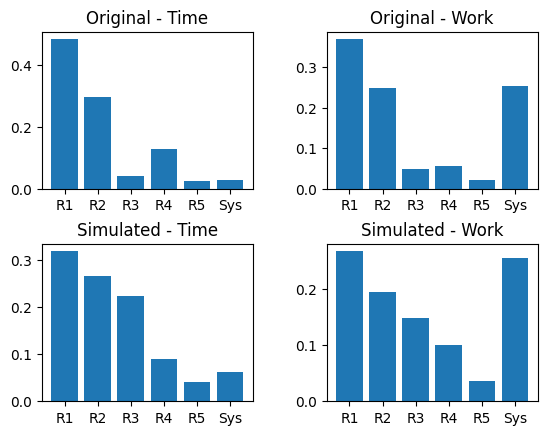

In [15]:
simulatedLog = pm4py.read_xes(simulatedLogPath)

dfOriginal, _  = GetActivityResourceMapping(originalLog)
dfSimulated, _ = GetActivityResourceMapping(simulatedLog)

# plot with various axes scales - https://matplotlib.org/3.1.1/gallery/pyplots/pyplot_scales.html#sphx-glr-gallery-pyplots-pyplot-scales-py
plt.figure()

def PlotChart(title, resources, data, plotargs):
    y_pos = np.arange(len(resources))

    plt.subplot(plotargs)
    
    # Create bars
    plt.bar(y_pos, data)

    # Create names on the x-axis
    plt.xticks(y_pos, [str(r)[0:3] for r in resources])
    plt.title(title)
    plt.grid(False)

PlotChart('Original - Time', dfOriginal['Resource'], dfOriginal['Relative-Time'], 221)
PlotChart('Original - Work', dfOriginal['Resource'], dfOriginal['Relative-Activities'], 222)

PlotChart('Simulated - Time', dfSimulated['Resource'], dfSimulated['Relative-Time'], 223)
PlotChart('Simulated - Work', dfSimulated['Resource'], dfSimulated['Relative-Activities'], 224)

# Set padding between subplots
plt.subplots_adjust(hspace=0.35, wspace=0.35)
plt.show()